# Code Similarity Using Graph Neural Networks

In this colab, we show how to use graph neural networks to compute code similarity between two pieces of code using the CodeXGlue POJ-104 dataset.

## Setup

First create a project folder in the your Google Drive

Mount Colab to drive to give it access to the project's file directory

In [15]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [16]:
import os
if not os.path.isfile('nx_pyg.py'):
  # Edit this location based on your project folder location
  os.chdir('/Users/tejanagubandi/Desktop/Master-1.1/IntroToMl/MLFinalProject/')
print(os.getcwd())

/Users/tejanagubandi/Desktop/Master-1.1/IntroToMl/MLFinalProject


Install required packages: PyTorch Geometric, PyTorch Sparse, and PyTorch Scatter

In [17]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-geometric
!pip install networkx
# !pip install clang

Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
You should consider upgrading via the '/Users/tejanagubandi/Desktop/Master-1.1/IntroToMl/MLFinalProject/MLFinalProject/bin/python3 -m pip install --upgrade pip' command.
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
You should consider upgrading via the '/Users/tejanagubandi/Desktop/Master-1.1/IntroToMl/MLFinalProject/MLFinalProject/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/tejanagubandi/Desktop/Master-1.1/IntroToMl/MLFinalProject/MLFinalProject/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/tejanagubandi/Desktop/Master-1.1/IntroToMl/MLFinalProject/MLFinalProject/bin/python3 -m pip install --upgrade pip' command.


Import relevant packages for training, visualisation, and data processing

In [18]:
import torch_geometric as pyg
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
import torch.optim as optim
from tqdm import trange
import matplotlib.pyplot as plt
from torch_geometric.nn.pool import SAGPooling
import copy
from torch_geometric.data import Batch, Dataset
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn import aggr
from torch_geometric.utils import softmax, from_networkx
from zipfile import ZipFile
import subprocess
import clang.cindex
import networkx as nx
import json

Define the model's hyperparameters and training setup parameters

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args = {'model_type': 'ORD', 'num_layers': 5, 'heads': 1, 'batch_size': 8, 'embedding_dim': 192, 'hidden_dim': 192, 'dropout': 0.5,
            'epochs': 50, 'opt': 'adam', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.001, 'device': device}
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

args = objectview(args)

## Creating the Dataset

Check if the data files `train.pt`, `valid.pt`, and `test.pt` already exist, and if they do, skip this section.

In [20]:
print(os.listdir('data/poj-104/'))

[]


First, we must download and preprocess the POJ-104 dataset. First download the [POJ-104 directory](https://github.com/microsoft/CodeXGLUE/tree/main/Code-Code/Clone-detection-POJ-104) as a directory named `Clone-detection-POJ-104` in the project folder. Then, follow the instructions in the directory to download and preprocess the dataset.

At the end of this, you should have `train.jsonl`, `valid.jsonl`, and `test.jsonl` in `./Clone-detection-POJ-104/dataset`

We now define some functions to convert node labels of an Abstract Syntax Tree (AST) into one-hot vectors

In [21]:
# Set of all possible node labels

NODE_LABELS = ['UNEXPOSED_DECL', 'STRUCT_DECL', 'UNION_DECL', 'CLASS_DECL', 'ENUM_DECL', 'FIELD_DECL',
               'ENUM_CONSTANT_DECL', 'FUNCTION_DECL', 'VAR_DECL', 'PARM_DECL', 'OBJC_INTERFACE_DECL',
               'OBJC_CATEGORY_DECL', 'OBJC_PROTOCOL_DECL', 'OBJC_PROPERTY_DECL', 'OBJC_IVAR_DECL',
               'OBJC_INSTANCE_METHOD_DECL', 'OBJC_CLASS_METHOD_DECL', 'OBJC_IMPLEMENTATION_DECL',
               'OBJC_CATEGORY_IMPL_DECL', 'TYPEDEF_DECL', 'CXX_METHOD', 'NAMESPACE', 'LINKAGE_SPEC', 'CONSTRUCTOR',
               'DESTRUCTOR', 'CONVERSION_FUNCTION', 'TEMPLATE_TYPE_PARAMETER', 'TEMPLATE_NON_TYPE_PARAMETER',
               'TEMPLATE_TEMPLATE_PARAMETER', 'FUNCTION_TEMPLATE', 'CLASS_TEMPLATE',
               'CLASS_TEMPLATE_PARTIAL_SPECIALIZATION', 'NAMESPACE_ALIAS', 'USING_DIRECTIVE', 'USING_DECLARATION',
               'TYPE_ALIAS_DECL', 'OBJC_SYNTHESIZE_DECL', 'OBJC_DYNAMIC_DECL', 'CXX_ACCESS_SPEC_DECL',
               'OBJC_SUPER_CLASS_REF', 'OBJC_PROTOCOL_REF', 'OBJC_CLASS_REF', 'TYPE_REF', 'CXX_BASE_SPECIFIER',
               'TEMPLATE_REF', 'NAMESPACE_REF', 'MEMBER_REF', 'LABEL_REF', 'OVERLOADED_DECL_REF', 'VARIABLE_REF',
               'INVALID_FILE', 'NO_DECL_FOUND', 'NOT_IMPLEMENTED', 'INVALID_CODE', 'UNEXPOSED_EXPR', 'DECL_REF_EXPR',
               'MEMBER_REF_EXPR', 'CALL_EXPR', 'OBJC_MESSAGE_EXPR', 'BLOCK_EXPR', 'INTEGER_LITERAL', 'FLOATING_LITERAL',
               'IMAGINARY_LITERAL', 'STRING_LITERAL', 'CHARACTER_LITERAL', 'PAREN_EXPR', 'UNARY_OPERATOR',
               'ARRAY_SUBSCRIPT_EXPR', 'BINARY_OPERATOR', 'COMPOUND_ASSIGNMENT_OPERATOR', 'CONDITIONAL_OPERATOR',
               'CSTYLE_CAST_EXPR', 'COMPOUND_LITERAL_EXPR', 'INIT_LIST_EXPR', 'ADDR_LABEL_EXPR', 'StmtExpr',
               'GENERIC_SELECTION_EXPR', 'GNU_NULL_EXPR', 'CXX_STATIC_CAST_EXPR', 'CXX_DYNAMIC_CAST_EXPR',
               'CXX_REINTERPRET_CAST_EXPR', 'CXX_CONST_CAST_EXPR', 'CXX_FUNCTIONAL_CAST_EXPR', 'CXX_TYPEID_EXPR',
               'CXX_BOOL_LITERAL_EXPR', 'CXX_NULL_PTR_LITERAL_EXPR', 'CXX_THIS_EXPR', 'CXX_THROW_EXPR', 'CXX_NEW_EXPR',
               'CXX_DELETE_EXPR', 'CXX_UNARY_EXPR', 'OBJC_STRING_LITERAL', 'OBJC_ENCODE_EXPR', 'OBJC_SELECTOR_EXPR',
               'OBJC_PROTOCOL_EXPR', 'OBJC_BRIDGE_CAST_EXPR', 'PACK_EXPANSION_EXPR', 'SIZE_OF_PACK_EXPR', 'LAMBDA_EXPR',
               'OBJ_BOOL_LITERAL_EXPR', 'OBJ_SELF_EXPR', 'OMP_ARRAY_SECTION_EXPR', 'OBJC_AVAILABILITY_CHECK_EXPR',
               'UNEXPOSED_STMT', 'LABEL_STMT', 'COMPOUND_STMT', 'CASE_STMT', 'DEFAULT_STMT', 'IF_STMT', 'SWITCH_STMT',
               'WHILE_STMT', 'DO_STMT', 'FOR_STMT', 'GOTO_STMT', 'INDIRECT_GOTO_STMT', 'CONTINUE_STMT', 'BREAK_STMT',
               'RETURN_STMT', 'ASM_STMT', 'OBJC_AT_TRY_STMT', 'OBJC_AT_CATCH_STMT', 'OBJC_AT_FINALLY_STMT',
               'OBJC_AT_THROW_STMT', 'OBJC_AT_SYNCHRONIZED_STMT', 'OBJC_AUTORELEASE_POOL_STMT',
               'OBJC_FOR_COLLECTION_STMT', 'CXX_CATCH_STMT', 'CXX_TRY_STMT', 'CXX_FOR_RANGE_STMT', 'SEH_TRY_STMT',
               'SEH_EXCEPT_STMT', 'SEH_FINALLY_STMT', 'MS_ASM_STMT', 'NULL_STMT', 'DECL_STMT', 'OMP_PARALLEL_DIRECTIVE',
               'OMP_SIMD_DIRECTIVE', 'OMP_FOR_DIRECTIVE', 'OMP_SECTIONS_DIRECTIVE', 'OMP_SECTION_DIRECTIVE',
               'OMP_SINGLE_DIRECTIVE', 'OMP_PARALLEL_FOR_DIRECTIVE', 'OMP_PARALLEL_SECTIONS_DIRECTIVE',
               'OMP_TASK_DIRECTIVE', 'OMP_MASTER_DIRECTIVE', 'OMP_CRITICAL_DIRECTIVE', 'OMP_TASKYIELD_DIRECTIVE',
               'OMP_BARRIER_DIRECTIVE', 'OMP_TASKWAIT_DIRECTIVE', 'OMP_FLUSH_DIRECTIVE', 'SEH_LEAVE_STMT',
               'OMP_ORDERED_DIRECTIVE', 'OMP_ATOMIC_DIRECTIVE', 'OMP_FOR_SIMD_DIRECTIVE',
               'OMP_PARALLELFORSIMD_DIRECTIVE', 'OMP_TARGET_DIRECTIVE', 'OMP_TEAMS_DIRECTIVE',
               'OMP_TASKGROUP_DIRECTIVE', 'OMP_CANCELLATION_POINT_DIRECTIVE', 'OMP_CANCEL_DIRECTIVE',
               'OMP_TARGET_DATA_DIRECTIVE', 'OMP_TASK_LOOP_DIRECTIVE', 'OMP_TASK_LOOP_SIMD_DIRECTIVE',
               'OMP_DISTRIBUTE_DIRECTIVE', 'OMP_TARGET_ENTER_DATA_DIRECTIVE', 'OMP_TARGET_EXIT_DATA_DIRECTIVE',
               'OMP_TARGET_PARALLEL_DIRECTIVE', 'OMP_TARGET_PARALLELFOR_DIRECTIVE', 'OMP_TARGET_UPDATE_DIRECTIVE',
               'OMP_DISTRIBUTE_PARALLELFOR_DIRECTIVE', 'OMP_DISTRIBUTE_PARALLEL_FOR_SIMD_DIRECTIVE',
               'OMP_DISTRIBUTE_SIMD_DIRECTIVE', 'OMP_TARGET_PARALLEL_FOR_SIMD_DIRECTIVE', 'OMP_TARGET_SIMD_DIRECTIVE',
               'OMP_TEAMS_DISTRIBUTE_DIRECTIVE', 'TRANSLATION_UNIT', 'UNEXPOSED_ATTR', 'IB_ACTION_ATTR',
               'IB_OUTLET_ATTR', 'IB_OUTLET_COLLECTION_ATTR', 'CXX_FINAL_ATTR', 'CXX_OVERRIDE_ATTR', 'ANNOTATE_ATTR',
               'ASM_LABEL_ATTR', 'PACKED_ATTR', 'PURE_ATTR', 'CONST_ATTR', 'NODUPLICATE_ATTR', 'CUDACONSTANT_ATTR',
               'CUDADEVICE_ATTR', 'CUDAGLOBAL_ATTR', 'CUDAHOST_ATTR', 'CUDASHARED_ATTR', 'VISIBILITY_ATTR',
               'DLLEXPORT_ATTR', 'DLLIMPORT_ATTR', 'CONVERGENT_ATTR', 'WARN_UNUSED_ATTR', 'WARN_UNUSED_RESULT_ATTR',
               'ALIGNED_ATTR', 'PREPROCESSING_DIRECTIVE', 'MACRO_DEFINITION', 'MACRO_INSTANTIATION',
               'INCLUSION_DIRECTIVE', 'MODULE_IMPORT_DECL', 'TYPE_ALIAS_TEMPLATE_DECL', 'STATIC_ASSERT',
               'FRIEND_DECL', 'OVERLOAD_CANDIDATE']

In [22]:
NODE_LABEL_INDEX_LOOKUP = {l: i for i, l in enumerate(NODE_LABELS)}

def label_to_one_hot(label):
    one_hot = torch.zeros(len(NODE_LABELS) + 1)
    if label in NODE_LABEL_INDEX_LOOKUP:
        one_hot[NODE_LABEL_INDEX_LOOKUP[label]] = 1
    else:
      # Not a known label, so set the last index to 1
      one_hot[-1] = 1
    return one_hot


def label_to_categorical(label):
    if label in NODE_LABEL_INDEX_LOOKUP:
        return int(NODE_LABEL_INDEX_LOOKUP[label])
    else:
      # Not a known label, so return the last index
      return len(NODE_LABELS)

To convert a string of code to a graph, we write it to a .cpp file and parse it using clang. We then recursive over all nodes in the parsed AST and add them and their edges to a NetworkX graph.

In [23]:
OUTPUT_FILENAME = 'output.cpp'

def get_root(cindex, input_filename, output_filename=OUTPUT_FILENAME):
    """
    Saves code string to .cpp file, parses it using clang, and returns root node of AST
    """
    with open(input_filename, 'r') as input, open(output_filename, 'w') as output:
        for line in input:
            output.write(line)

    root = cindex.parse(output_filename)
    return root


def traverse_ast(node, parent=None, graph=None):
    """
    Recurse over AST and add nodes and edges to NetworkX graph
    """
    # Base case
    if graph is None:
        graph = nx.DiGraph()
    if node.kind.is_unexposed():
        # Unexposed nodes are compiler specific and should be skipped over
        for child in node.get_children():
            traverse_ast(child, parent, graph)
    else:
        # Add the current node to the graph
        node_id = str(node.hash)
        node_label = node.kind.name
        if str(node_label)[-7:] == "LITERAL":
            # Differentiating string literals and other numeric literals
            if node_label[:6] == "STRING":
                # Save string data as node value
                graph.add_node(node_id, node_label=label_to_categorical(node_label), node_val = node.spelling)
            else:
                try:
                    val = next(node.get_tokens()).spelling
                except StopIteration:
                    val = None
                # Save other literal value as node value
                graph.add_node(node_id, node_label=label_to_categorical(node_label), node_val = val)

        else:
            # Non-literal added with empty value
            graph.add_node(node_id, node_label=label_to_categorical(node_label), node_val = '')

        # Add an edge from the current node to its parent
        if parent is not None:
            graph.add_edge(node_id, parent)
        # Recursively traverse the children of the current node
        for child in node.get_children():
            traverse_ast(child, node_id, graph)
    return graph

Putting it together, we convert a code string to a PyG Data object

In [24]:
def txt_to_nx_graph(index, input_filename, output_filename=OUTPUT_FILENAME):
    root = get_root(index, input_filename, output_filename)
    graph = traverse_ast(root.cursor)
    return graph

def to_pyg(nx_graph):
  data = from_networkx(nx_graph)
  data.x = torch.nn.functional.one_hot(data.node_label, num_classes=len(NODE_LABELS) + 1)
  return data

def txt_to_pyg_data(cindex, input_filename, task_label, index):
    ast_graph = txt_to_nx_graph(cindex, input_filename)
    pyg_data = to_pyg(ast_graph)
    pyg_data.task_label = task_label
    pyg_data.index = index
    return pyg_data

Finally, we iterate over each dataset JSON file to convert all code string instances into a list of labelled PyG Data objects

In [25]:
def json_to_pyg_dataset(cindex, input_filename, output_filename, stop_at=None):
    pyg_dataset = []
    with open(input_filename, 'r') as f:
        for line in f:
            item = json.loads(line)
            tmp_filename = 'tmp.txt'
            with open(tmp_filename, 'w') as f:
                f.write(item['code'])
            pyg_data = txt_to_pyg_data(cindex, tmp_filename, int(item['label']), int(item['index']))
            pyg_dataset.append(pyg_data)
            if stop_at is not None and len(pyg_dataset) == stop_at:
                break
    torch.save(pyg_dataset, output_filename)
    print(len(pyg_dataset))

In [26]:
if not set(['train.pt', 'valid.pt', 'test.pt']).issubset(set(os.listdir('data/poj-104/'))):
    # set libclang path
    LIBCLANG_PATH = '/Library/Developer/CommandLineTools/usr/lib/libclang.dylib'

    # create an index
    clang.cindex.Config.set_library_file(LIBCLANG_PATH)
    cindex = clang.cindex.Index.create()

Check if the data files already exist. If they are not, generate the dataset. This may take 5-10 minutes.

In [27]:
if not set(['train.pt', 'valid.pt', 'test.pt']).issubset(set(os.listdir('data/poj-104/'))):
    # generate dataset
    json_to_pyg_dataset(cindex, 'train.jsonl', 'data/poj-104/train.pt')
    json_to_pyg_dataset(cindex, 'valid.jsonl', 'data/poj-104/valid.pt')
    json_to_pyg_dataset(cindex, 'test.jsonl', 'data/poj-104/test.pt')

32000
8000
12000


Confirm the dataset is generated

In [28]:
print(os.listdir('data/poj-104/'))

['train.pt', 'valid.pt', 'test.pt']


## Defining the Model, Metric, and Optimiser

An OrderGNN layer resembles GraphSAGE layer in its message and self-loop aggregation. It extends GraphSAGE's expressivity by using LSTM aggregation with the ordering of the source graph as AST nodes are ordered

In [29]:
class OrderGNN(MessagePassing):
    def __init__(self, in_channels, out_channels, normalize = False,
                 bias = False, **kwargs):
        super(OrderGNN, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.lin_l = nn.Linear(in_channels, out_channels, bias=bias)
        self.lin_r = nn.Linear(in_channels, out_channels, bias=bias)
        self.reset_parameters()
        self.aggr = aggr.LSTMAggregation(in_channels, out_channels)

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        pyg.utils.add_self_loops(edge_index)
        out = self.propagate(edge_index, x=(x, x), size=size).type(torch.float32)

        if self.normalize:
            out = F.normalize(out, p=2., dim=-1)
        return out

    def message(self, x_j):
        out = self.lin_l(x_j)

        return out

    def aggregate(self, inputs, index, dim_size = None):
        # sort indices to assign LSTM order
        inds = torch.argsort(index, stable=True)
        inputs = inputs[inds, :]
        index = index[inds]
        node_dim = self.node_dim
        if index.shape[0] > 0:
            out = self.aggr(inputs, index, dim_size=dim_size)
        else:
            # use mean aggregation to use GraphSAGE behaviour
            out = torch_scatter.scatter(inputs, index, dim=node_dim, dim_size=dim_size, reduce='mean')
        return out

The GNNStack class defines the full GNN with GAT, GraphSAGE, or OrderGNN convolutional layers, MLP post-processing layers, dropout regularisation, and SAGPooling to pool node embeddings into a graph embedding.

In [30]:
class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        self.node_emb_lookup = nn.Linear(210, args.hidden_dim)
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        if args.model_type != 'GAT':
          for l in range(args.num_layers):
              self.convs.append(conv_model(hidden_dim, hidden_dim))
        else:
          for l in range(args.num_layers):
              self.convs.append(conv_model(hidden_dim, hidden_dim, heads = args.heads, concat=False))

        # post-processing after message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(args.dropout),
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers
        self.sag_pooling = SAGPooling(hidden_dim, ratio=0.5)

    def build_conv_model(self, model_type):
        if model_type == 'GS':
            return pyg.nn.SageConv
        if model_type == 'GAT':
            return pyg.nn.GATConv
        if model_type == 'ORD':
            return OrderGNN

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = x.type(torch.float32)
        x = self.node_emb_lookup(x)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            if i == 1:
              x, edge_index, _, batch, _, _ = self.sag_pooling(x, edge_index, None, batch)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)

        x = self.post_mp(x)
        x = pyg.nn.global_mean_pool(x, batch)
        return x

In [31]:
def build_optimizer(args, params):
    """
    Defines a given optimiser for parameters requiring gradients given
    weight decay and learning rate in args
    """
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    return optimizer

As our training objective, we use [Circle Loss](https://arxiv.org/abs/2002.10857), a contrastive loss that jointly maximises within-class similarlity $s_p$ and minimises between-class similarity $s_n$ with a margin for a more definite convergence target.

The following functions define the CircleLoss metric and were adapted from [MISIM: A Neural Code Semantics Similarity System Using the Context-Aware Semantics Structure](https://arxiv.org/abs/2006.05265).

In [32]:
# Computes pairwise cosine similarity for a set of embeddings
def pairwise_cosine_similarity(h):
    h_norm = F.normalize(h, dim=1)
    sim = torch.mm(h_norm, h_norm.transpose(0, 1))
    return sim

# Computes within-class and between-class scores for given embeddings
def compute_scores(h, pids):
    sim = pairwise_cosine_similarity(h)
    inds = torch.triu_indices(len(pids), len(pids), offset=1)
    sim = sim[inds[0], inds[1]]
    positive = pids[inds[0]] == pids[inds[1]]
    s_p = sim[positive]
    s_n = sim[~positive]
    return s_p, s_n


class CircleLoss(nn.Module):
    def __init__(self, gamma=80, m=0.4):
        super().__init__()
        self.gamma = gamma    # scale factor
        self.m = m            # margin

    # compute circle loss given within and between class scores
    def forward(self, s_p, s_n):
        alpha_p = torch.clamp_min(1 + self.m - s_p, 0)
        alpha_n = torch.clamp_min(self.m + s_n, 0)
        delta_p = 1 - self.m
        delta_n = self.m
        logit_p = (-self.gamma) * alpha_p * (s_p - delta_p)
        logit_n = self.gamma * alpha_n * (s_n - delta_n)
        return F.softplus(torch.logsumexp(logit_p, dim=0) + torch.logsumexp(logit_n, dim=0))

For consistency with CodeXGlue benchmarking, we evaluate performance based on mean average precision at r, i.e. MAP@R.

The below function implements this and has been adapated from [MISIM: A Neural Code Semantics Similarity System Using the Context-Aware Semantics Structure](https://arxiv.org/abs/2006.05265).

In [33]:
# Adapted from MISIM: A Neural Code Semantics Similarity System Using the Context-Aware Semantics Structure

def mapar(predictions, label, recall = None):
    label = torch.tensor([int(z) for z in label]).cpu().numpy()
    x = F.normalize(predictions, dim = 1).cpu().numpy()
    sim = x @ x.T
    r = np.bincount(label) - 1
    max_r = r.max()

    mask = np.arange(max_r)[None, :] < r[label][:, None]

    ind = np.diag_indices(len(sim))
    sim[ind[0], ind[1]] = -np.inf
    simx = torch.tensor(sim)

    _, result = torch.topk(simx, max_r, dim=1, sorted=True)
    result = result.numpy()

    tp = (label[result] == label[:, None])
    tp[~mask] = False

    valid = r[label] > 0

    p = np.cumsum(tp, axis=1) / np.arange(1, max_r+1)[None, :]
    ap = (p * tp).sum(axis=1)[valid] / r[label][valid]

    return ap.mean().item()

## Train and Evaluate the Model

In [34]:
def train(train_loader, valid_loader, args, model, opt):
    """
    Train given model with a given optimizer, train and validation datasets, and train parameters
    Returns lists of per-epoch validation errors, losses, and MAP@R.
    Also returns model with lowest validation error and best MAP@R.
    """
    losses = []
    valid_errs = []
    mapars = []
    best_err = float('inf')
    best_model = None
    criterion = CircleLoss()
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        for i, batch in enumerate(train_loader):
            opt.zero_grad()
            predictions = model(batch)
            label = batch.task_label
            label = torch.tensor([int(x) for x in label])
            sp, sn = compute_scores(predictions, label)
            loss = criterion(sp, sn)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(train_loader.dataset)
        losses.append(total_loss)

        if epoch % 1 == 0:
            valid_err, mavp = test(valid_loader, model)
            valid_errs.append(valid_err)
            mapars.append(mavp)
            if valid_err < best_err:
                best_err = valid_err
                best_model = copy.deepcopy(model)
                torch.save(best_model.state_dict(), args.model_type + '.pt')
        else:
            valid_errs.append(valid_errs[-1])

    return valid_errs, losses, best_model, best_err, mapars

In [35]:
def test(loader, test_model, verbose=False):
    """
    Evaluate model with a given dataloader, typically for a validation or test set
    """

    test_model.eval()

    error = 0
    divisor = len(loader.dataset)
    criterion = CircleLoss()
    for i, batch in enumerate(loader):
        overall_pred = None
        overall_label = []
        with torch.no_grad():
            predictions = test_model(batch)
            label = batch.task_label
            sp, sn = compute_scores(predictions, label)
            loss = criterion(sp, sn)
            if overall_pred == None:
                overall_pred = predictions
            else:
                overall_pred = torch.cat([overall_pred, predictions])
            overall_label += label
        error += loss
    error /= divisor
    mavp = mapar(overall_pred, overall_label, recall = 500)
    return float(error), mavp

In [36]:
# Load saved pretrained model if it exists
if os.path.isfile(args.model_type + '.pt'):
    model = GNNStack(args.embedding_dim, args.hidden_dim, args.embedding_dim, args)
    model.load_state_dict(torch.load(args.model_type + '.pt'))
else:
    model = GNNStack(args.embedding_dim, args.hidden_dim, args.embedding_dim, args)

model=model.to(device)
opt = build_optimizer(args, model.parameters())

The below code loads the train and validation datasets from disk into DataLoader objects with underlying Data objects on the GPU for optimal speed.

In order to conserve system RAM, the datasets are loaded from disk as a list of Data objects, each of which is then moved into GPU memory. The loaded dataset is then deleted, and the in-GPU dataset is loaded into a DataLoader.

In [37]:
train_dataset = torch.load('data/poj-104/train.pt')
train_dataset_gpu = [data.to(device) for data in train_dataset]
del train_dataset
train_loader = DataLoader(train_dataset_gpu, batch_size=args.batch_size, shuffle=True)
print(f"32000 training graphs")

valid_dataset = torch.load('data/poj-104/valid.pt')
valid_dataset_gpu = [data.to(device) for data in valid_dataset]
del valid_dataset
valid_loader = DataLoader(valid_dataset_gpu, batch_size=args.batch_size, shuffle=True)
print(f"8000 validation graphs")

32000 training graphs
8000 validation graphs


Train the model

In [38]:
valid_errs, losses, best_model, best_err, mapars = train(train_loader, valid_loader, args, model, opt)
print(f'Minimum loss: {min(losses)}')

Training:   2%|▏         | 1/50 [24:13<19:47:22, 1453.92s/Epochs]

Visualise training losses and validation errors and MAP@R over training epochs

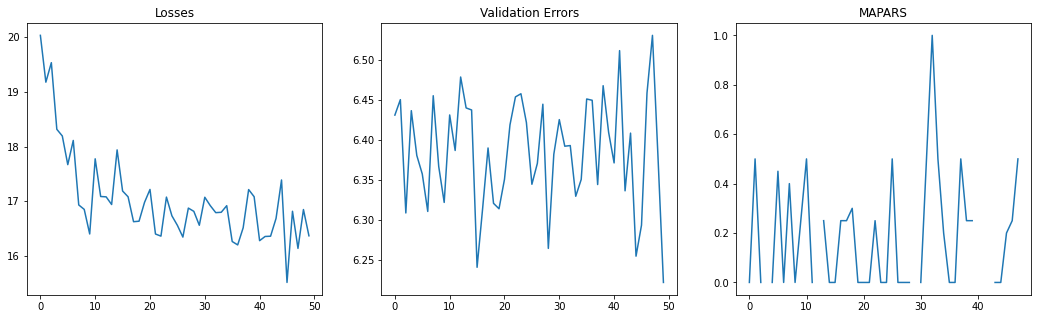

1.0


In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.plot(losses)
ax1.set_title('Losses')

ax2.plot(valid_errs)
ax2.set_title('Validation Errors')

ax3.plot(mapars)
ax3.set_title('MAPARS')

plt.show()
print(max(mapars))

## Test the Model

In the same way as the train and validation datasets, this loads the test dataset

In [ ]:
test_dataset = torch.load('data/poj-104/test.pt')
test_dataset_gpu = [data.to(device) for data in test_dataset]
del test_dataset
test_loader = DataLoader(test_dataset_gpu, batch_size=args.batch_size, shuffle=True)

Compute the test MAP@R to benchmark the model

In [ ]:
_, mapar_test = test(test_loader, best_model, verbose=True)
print(mapar_test)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


0.0
